In [5]:
import os
import matplotlib.pyplot as plt
import config
import numpy as np
import cv2
import random
from sklearn.utils import shuffle
from data import read_samples_from_file

root_path = os.getcwd()
data_folder = os.path.join(root_path, config.DATASET_ROOT_PATH)

image_paths, measurements = read_samples_from_file(os.path.join(data_folder, config.DRIVING_LOG),
                                                   config.STEERING_CORRECTION)

# print the length of the dataset
print('image_paths: {}'.format((len(image_paths))))
print('measurements: {}'.format((len(measurements))))


image_paths: 10433
measurements: 10433


### Steering Angle Disttibution

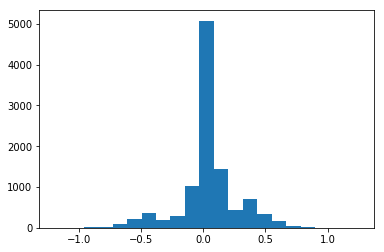

In [ ]:
# show the distribution of the steering angles in the dataset
plt.hist(measurements[:, 0], bins=config.NUM_DATA_BINS)
plt.savefig(os.path.join(root_path, './examples/steering_distribution_before.png'))
plt.show()

In [83]:
from data import distribute_data

# make a even distribution of the steering angles
X_train, y_train = distribute_data(image_paths, measurements)

# print the length of the train- and validation data
print('X_train: {}'.format((len(X_train))))
print('y_train: {}'.format((len(y_train))))

X_train: 73643
y_train: 73643


### Steering Angle Disttibution After Compensation

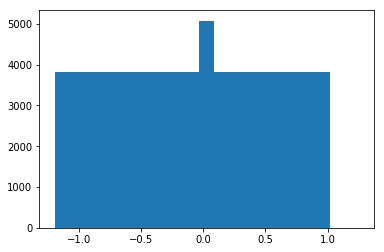

In [ ]:
# show the new distribution of the steering angles after the compensation
plt.hist(y_train[:, 0], bins=config.NUM_DATA_BINS)
plt.savefig(os.path.join(root_path, './examples/steering_distribution_after.png'))
plt.show()

### Image Augmentation Methods

In [6]:
# read image from dataset
def read_image(filename):
    return cv2.imread(os.path.join(data_folder, filename))


# image augmentation methods:
# apply random brightness to the image to simulate sunlight, darkness, shadows, ect.
def random_brightness(img):
    # Convert 2 HSV colorspace from BGR colorspace
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # Generate new random brightness
    rand = random.uniform(0.3, 1.0)
    hsv[:, :, 2] = rand * hsv[:, :, 2]
    # Convert to RGB colorspace
    new_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return new_img


# shift the image randomly horizontal and vertical to simulate a wobble of the camera
def random_shift(img, angle):
    # random shift image and transform steering angle
    trans_range = 80
    shift_x = trans_range * np.random.uniform() - trans_range / 2
    shift_y = 40 * np.random.uniform() - 40 / 2
    M = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    new_img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
    delta_angle = shift_x / trans_range * 2 * 0.2
    return new_img, angle + delta_angle


# flip the image horizontally to simulate the mirror situation
def flip_horizontal(img, angle):
    return cv2.flip(img, 1), -angle


In [7]:
def show_images(images, titles):
    num = len(images)
    f, ax = plt.subplots(1, num, figsize=(12, 4))
    f.tight_layout()
    
    for i in range(num):
        ax[i].axis('off')
        ax[i].imshow(images[i])
        ax[i].set_title(titles[i], fontsize=16)
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return plt

### Sample Image

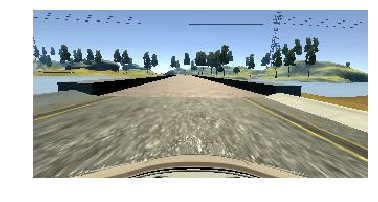

In [14]:
sample_image = read_image('IMG/center_2016_12_01_13_46_07_718.jpg')
plt.axis('off')
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.savefig(os.path.join(root_path, './examples/sample_image.png'))
plt.show()

### Crop Image

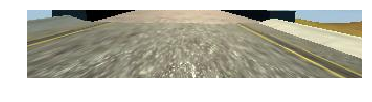

In [15]:
cropped_image = sample_image[70:135, :, :]
plt.axis('off')
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.savefig(os.path.join(root_path, './examples/cropped_image.png'))
plt.show()

### Random Brightness

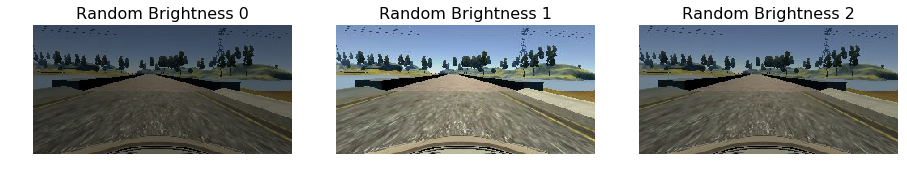

In [125]:
images = []
titles = []
for i in range(3):
    images.append(random_brightness(sample_image))
    titles.append('Random Brightness {}'.format(i))
    
plt = show_images(images, titles)
plt.savefig(os.path.join(root_path, './examples/random_brightness.png'))

### Random Shift

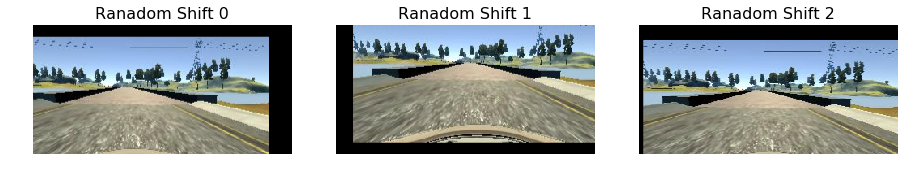

In [89]:
images = []
titles = []
for i in range(3):
    image, angle = random_shift(sample_image, 0)
    images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)) 
    titles.append('Ranadom Shift {}'.format(i))
    
plt = show_images(images, titles)
plt.savefig(os.path.join(root_path, './examples/random_shift.png'))

### Horiziontal Flip

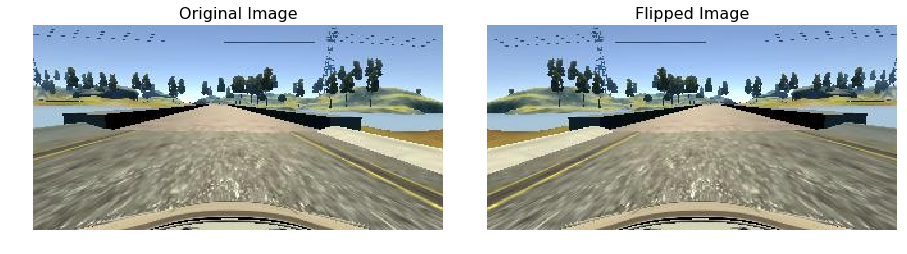

In [90]:
images = [cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB),
          cv2.cvtColor(flip_horizontal(sample_image, 0)[0], cv2.COLOR_BGR2RGB)]
titles = ['Original Image', 'Flipped Image']
    
plt = show_images(images, titles)
plt.savefig(os.path.join(root_path, './examples/horizontal_flip.png'))

### Image Augmentation

In [108]:
# train generator, uses image augmentation and horizontal flip
def generate_train_batch(image_paths, measurements, batch_size):
    while True:
        image_paths, measurements = shuffle(image_paths, measurements)

        for i in range(0, len(image_paths), batch_size):

            batch_images = []
            batch_steerings = []

            batch_image_paths = image_paths[i: i + batch_size]
            batch_measurements = measurements[i: i + batch_size]

            for image_name, (steering, throttle, brake, speed) in zip(batch_image_paths, batch_measurements):
                image = read_image(image_name)
                image = random_brightness(image)
                image, steering = random_shift(image, steering)

                if random.randint(0, 1) == 1:
                    image, steering = flip_horizontal(image, steering)

                batch_images.append(image)
                batch_steerings.append(steering)

            yield shuffle(np.array(batch_images), np.array(batch_steerings))
            
train_generator = generate_train_batch(X_train, y_train, 12)

In [113]:
def show_image_batch(images):
    rows = 3
    columns = 4
    
    f, ax = plt.subplots(rows, columns, figsize=(12, 4))
    f.tight_layout()
    
    for row in range(rows):
        for col in range(columns):
            ax[row, col].axis('off')
            ax[row, col].imshow(images[row+col])
        
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return plt

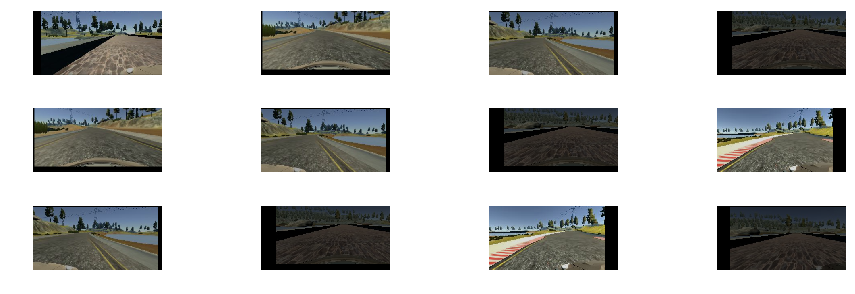

In [115]:
images, angles = next(train_generator)
plt = show_image_batch(images)
plt.savefig(os.path.join(root_path, './examples/train_image_batch.png'))